In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from astropy.time import Time
from astropy.table import Table
from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time
from scipy.interpolate import interp1d
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from astropy import constants as const
from flarestack.cosmo import get_rate, define_cosmology_functions, cumulative_z

No scratch directory has been set. Using home directory as default.


In [2]:
obs = pd.read_csv("data/nu_alerts_observed.csv", skiprows=[0, 1, 2])

obs = obs[~np.isnan(obs["RA"])]

In [3]:
ztf_lim_mag = 20.5
wl_g = 470*u.nm

In [4]:
p_spatial = 0.9 * (obs["Observed area (corrected for chip gaps)"]/obs['Area (rectangle)'])

s = np.array(obs["Signalness"])
s[np.isnan(s)] = 0.5

p_det = np.array(p_spatial * s).reshape(len(s), 1)

def p_no(f):
    
    p_no_i = np.ones_like(f) - p_det*f
        
    p_no_all = np.ones_like(f)
    for x in p_no_i:
        p_no_all *= x.T
    return p_no_all

x = np.linspace(0., 1., 101)
y = p_no(x)

# from scipy.interpolate import interp1d

f = interp1d(y, x)

print(p_no(np.array([1.])))

[1.37040101e-05]


In [5]:
text = r"""
\begin{table}
\centering
    \begin{tabular}{||c | c c | c ||} 
         \hline
         \textbf{Event} & P$_{\textup{signalness}}$ & P$_{\textup{obs}}$ & P$_{\textup{det}}$(f=1) \\
         \hline
"""

for index, row in obs.iterrows():
    
    name = str(row["Event"].lower())
        
    ras = json.loads(row["RA Unc (rectangle)"])
    
    decs = json.loads(row["Dec Unc (rectangle)"])    
    
    delta_r = ras[0] - ras[1]
    delta_d = decs[0] - decs[1]
    
    area = delta_r * delta_d  * np.cos(np.radians(float(row["Dec"])))
    
    if np.isnan(float(row["Signalness"])):
        s = "-"
        sig = 0.5
    else:
        s = f'{100.*row["Signalness"]:.0f}\%'
        sig = row["Signalness"]
        
    p_spatial = 0.9*row["Observed area (corrected for chip gaps)"]/area
    
    p_det = p_spatial * sig
                        
    text += f'\t {row["Event"]} & {sig:.2f} & {p_spatial:.2f} & {p_det:.2f} \\\\ \n'
    
text += f"""
    \hline
    \end{{tabular}}
    \caption{{Probability of detecting a counterpart for each neutrino, assuming counterparts are brighter than the limiting magnitude of the ZTF neutrino follow-up program.}}
    \label{{tab:nu_alert_probs}}
\end{{table}}
"""

print(text)


\begin{table}
\centering
    \begin{tabular}{||c | c c | c ||} 
         \hline
         \textbf{Event} & P$_{\textup{signalness}}$ & P$_{\textup{obs}}$ & P$_{\textup{det}}$(f=1) \\
         \hline
	 IC190503A & 0.36 & 0.63 & 0.23 \\ 
	 IC190619A & 0.55 & 0.71 & 0.39 \\ 
	 IC190730A & 0.67 & 0.75 & 0.50 \\ 
	 IC190922B & 0.51 & 0.82 & 0.42 \\ 
	 IC191001A & 0.59 & 0.81 & 0.48 \\ 
	 IC200107A & 0.50 & 0.74 & 0.37 \\ 
	 IC200109A & 0.77 & 0.89 & 0.69 \\ 
	 IC200117A & 0.38 & 0.84 & 0.32 \\ 
	 IC200512A & 0.32 & 0.85 & 0.27 \\ 
	 IC200530A & 0.59 & 0.79 & 0.46 \\ 
	 IC200620A & 0.32 & 0.65 & 0.21 \\ 
	 IC200916A & 0.32 & 0.77 & 0.25 \\ 
	 IC200926A & 0.44 & 0.66 & 0.29 \\ 
	 IC200929A & 0.47 & 0.70 & 0.33 \\ 
	 IC201007A & 0.88 & 0.87 & 0.76 \\ 
	 IC201021A & 0.30 & 0.82 & 0.25 \\ 
	 IC201130A & 0.15 & 0.75 & 0.11 \\ 
	 IC201209A & 0.19 & 0.61 & 0.12 \\ 
	 IC201222A & 0.53 & 0.82 & 0.43 \\ 
	 IC210210A & 0.65 & 0.67 & 0.43 \\ 
	 IC210510A & 0.28 & 0.82 & 0.23 \\ 
	 IC210629A & 0.35 & 0.6

No more than 13.4% (68% CL) of neutrino sources can have a magnitude greater than our limiting magnitude of 20.5


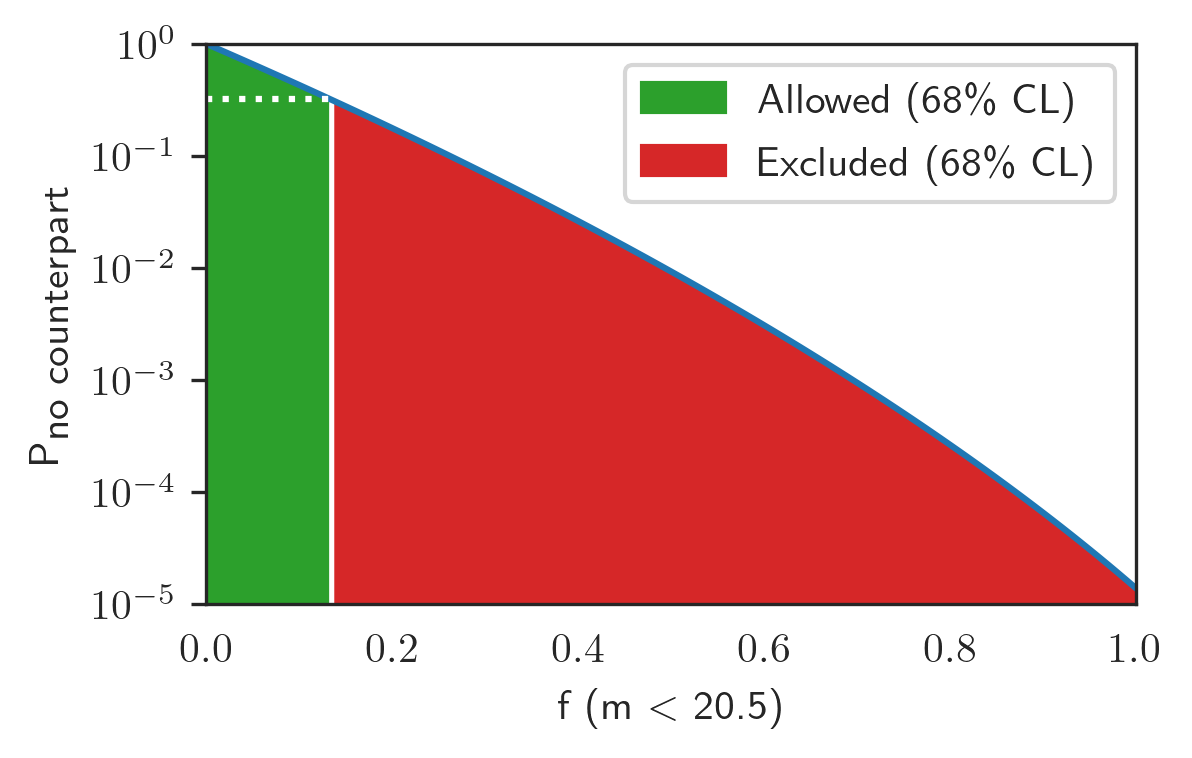

In [6]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)

ax = plt.subplot(111)

plt.plot(x, y)

log=True

# for cl in [0.90]:
for cl in [0.68]:
    
    ul = f(1.-cl)

    print(f"No more than {ul*100.:.1f}% ({cl*100.:.0f}% CL) of neutrino sources can have a magnitude greater than our limiting magnitude of {ztf_lim_mag:.1f}")
    
#     plt.plot([ul, ul], [0., 1.-cl], color='w', linestyle=":")
    plt.plot([0.0, ul], [1.-cl, 1.-cl], color='w', linestyle=":")
    
    mask = x > ul
    
    plt.fill_between(x[~mask], y[~mask], 0., color="C2", label=f"Allowed ({cl*100.:.0f}\% CL)", zorder=2)
    plt.fill_between(x[mask], y[mask], 0., color="C3", label=f"Excluded ({cl*100.:.0f}\% CL)", zorder=1)
#     plt.fill_between(x[~mask], 1.-cl, 0., color="r")
    
plt.xlim(0.0, 1.0)

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)

plt.xlabel(f"f (m $<$ {ztf_lim_mag:.1f})", fontsize=big_fontsize)
plt.ylabel(r"P$_{\textup{no counterpart}}$", fontsize=big_fontsize)
plt.legend(fontsize=big_fontsize)


if log:
    plt.yscale("log")

    yticks = np.logspace(-5, 0, 6)

    plt.ylim(yticks[0], yticks[-1])
    plt.yticks(yticks)
    yarrow = np.exp(np.mean([np.log(1.-cl), yticks[0]]))
else:
    plt.ylim(0.0, 1.0)
    yarrow = np.mean([1.-cl, 0.])

ax2 = ax.twinx()

w = 0.3

# plt.arrow(ul, yarrow, -0.1, 0.0, color="r")
plt.ylim(0.0 + w, 1.0 - w)
ax2.set_axis_off()

filename = "limit_app_mag.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

No more than 13.4% (68% CL) of neutrino sources can have a magnitude greater than our limiting magnitude of 20.5


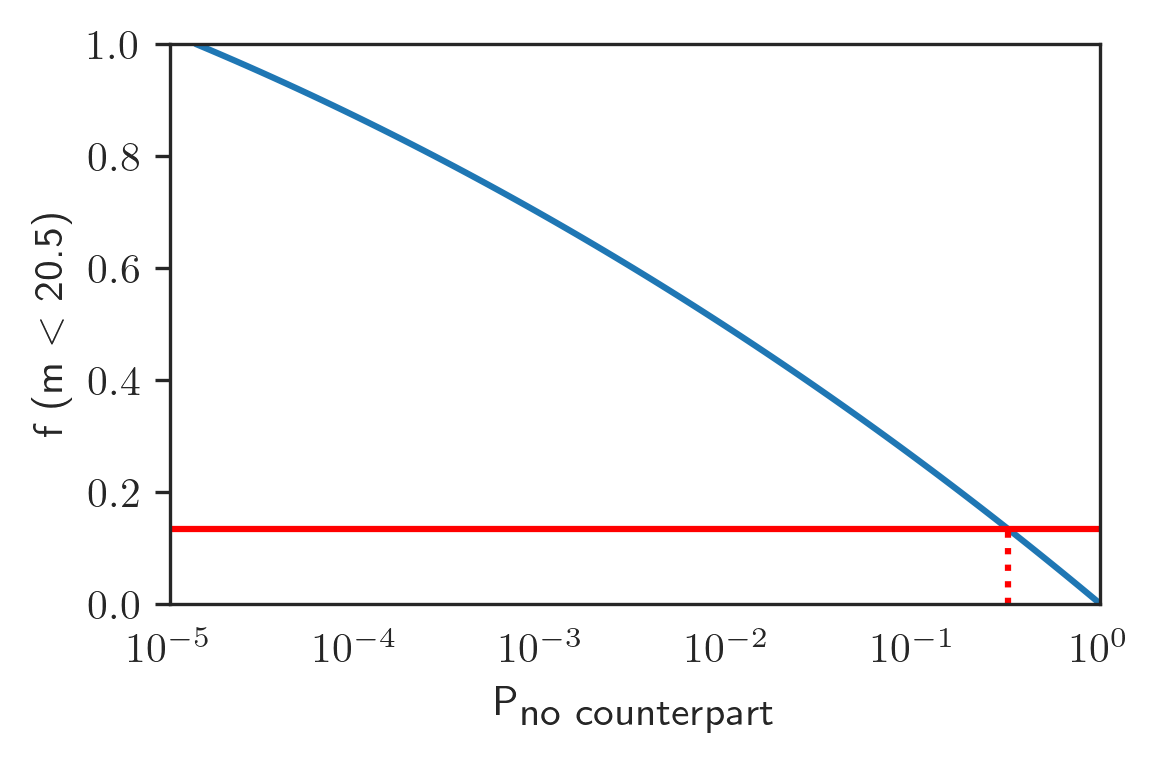

In [7]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)

ax = plt.subplot(111)

plt.plot(y, x)

log=True

# for cl in [0.90]:
for cl in [0.68]:
    
    ul = f(1.-cl)

    print(f"No more than {ul*100.:.1f}% ({cl*100.:.0f}% CL) of neutrino sources can have a magnitude greater than our limiting magnitude of {ztf_lim_mag:.1f}")
    
    plt.axhline(ul, color="r")
    plt.plot([1.-cl, 1.-cl], [0.0, ul], color='r', linestyle=":")
plt.ylim(0.0, 1.0)

if log:
    plt.xscale("log")

    xticks = np.logspace(-5, 0, 6)

    plt.xlim(xticks[0], xticks[-1])
    plt.xticks(xticks)
else:
    plt.xlim(0.0, 1.0)


plt.tick_params(axis='both', which='major', labelsize=big_fontsize)

plt.ylabel(f"f (m $<$ {ztf_lim_mag:.1f})", fontsize=big_fontsize)
plt.xlabel(r"P$_{\textup{no counterpart}}$", fontsize=big_fontsize)

ax2 = ax.twinx()

w = 0.3

plt.arrow(0.5, ul, 0.0, -0.1, color="r", label=f"Upper Limit ({cl*100.:.0f}% CL)")
plt.ylim(0.0 + w, 1.0 - w)
ax2.set_axis_off()

# filename = "limit_app_mag.pdf"

# output_path = os.path.join(output_folder, filename)
# plt.savefig(f"plots/{filename}")
# plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

Text(0.5, 0, 'Redshift')

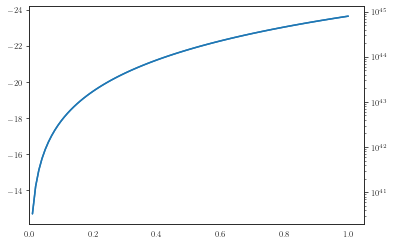

In [8]:
def abs_mag(z, lim_mag=ztf_lim_mag):
    
    dl = cosmo.luminosity_distance(z=z).to(u.pc)
    
    ab_mag = lim_mag - 5. * np.log10(dl/(10.*u.pc))
    
    return ab_mag.value

def max_dl(ab_mag, lim_mag=ztf_lim_mag):
    
    dl = (10.**(0.2*(lim_mag - ab_mag))) * (10.*u.pc)
    
    return dl.to(u.Mpc)

def abs_mag_to_lum(ab_mag, wl=wl_g):
    am = (ab_mag * u.ABmag).to(u.Jansky)
    f = (const.c / wl).to("Hz")
    lum = (am * f * (4. * np.pi * (10. * u.pc)**2.)).to("erg s-1")
    return lum

z_range = np.linspace(0.0, 1.0, 101)[1:]

plt.figure()
ax = plt.subplot(111)
ax2 = ax.twinx()
ax.plot(z_range, abs_mag(z_range))

ax2.plot(z_range, abs_mag_to_lum(abs_mag(z_range)))
ax2.set_yscale("log")
ax.invert_yaxis()

plt.xlim(left=0.0)
plt.xlabel("Redshift")

In [9]:
rates = [
    ("TDE", get_rate("tde")),
    ("GRB", get_rate("GRB")),
#     ("TDE (Jetted)", get_rate("tde", rate_name="sun_15_jetted")),
    ("CCSN (Madau)", get_rate("ccsn", rate_name="madau_14", evolution_name="madau_14", kcc_name="madau_14")),
    ("CCSN (Strolger)", get_rate("ccsn", rate_name="strolger_15", evolution_name="strolger_15", kcc_name="strolger_15")),
]

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

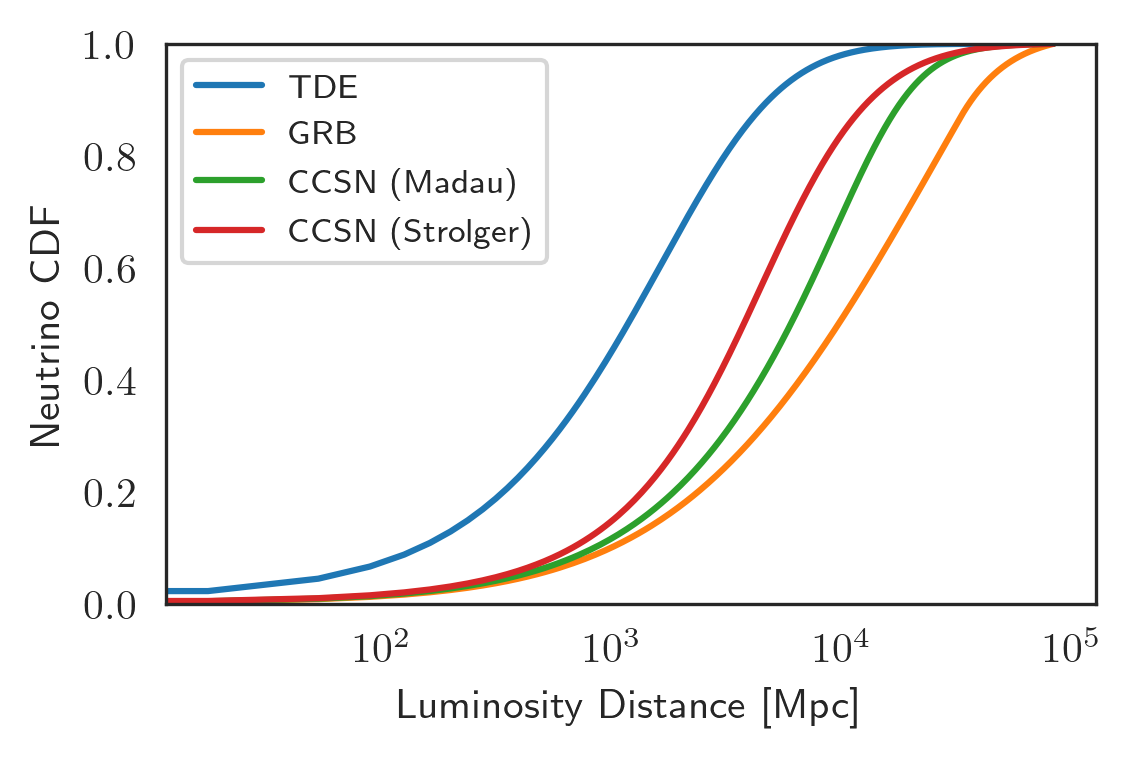

In [10]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax = plt.subplot(111)

nsteps = 1e3
zrange, step = np.linspace(0.0, 8.0, int(nsteps + 1), retstep=True)
zplot = 0.5*(zrange[1:] + zrange[:-1])

cdf_mpc = dict()

for label, rate in rates:
    
    rate_per_z, nu_flux_per_z, nu_flux_per_source, cumulative_nu_flux = \
            define_cosmology_functions(rate, 1., gamma=2.0)

    y = [x.value for x in cumulative_nu_flux(8.)]
    y = np.array(y)/y[-1]

    # y /= y[-1]

    # y = [cumulative_nu_flux(i)[-1]/max_scale for i in z]
    
    dls = [0.] + [dl.value for dl in cosmo.luminosity_distance(zplot)]
    
    plt.plot(dls, [0.] + list(y), label=label)
    
    cdf_mpc[label] = interp1d(dls, [0.] + list(y))

plt.ylim(0.0, 1.0)
plt.xscale("log")
plt.xlabel("Luminosity Distance [Mpc]", fontsize=big_fontsize)
plt.ylabel("Neutrino CDF", fontsize=big_fontsize)
ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend()

filename = "neutrino_CDF.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [11]:
print(ul)

0.13361700025956313


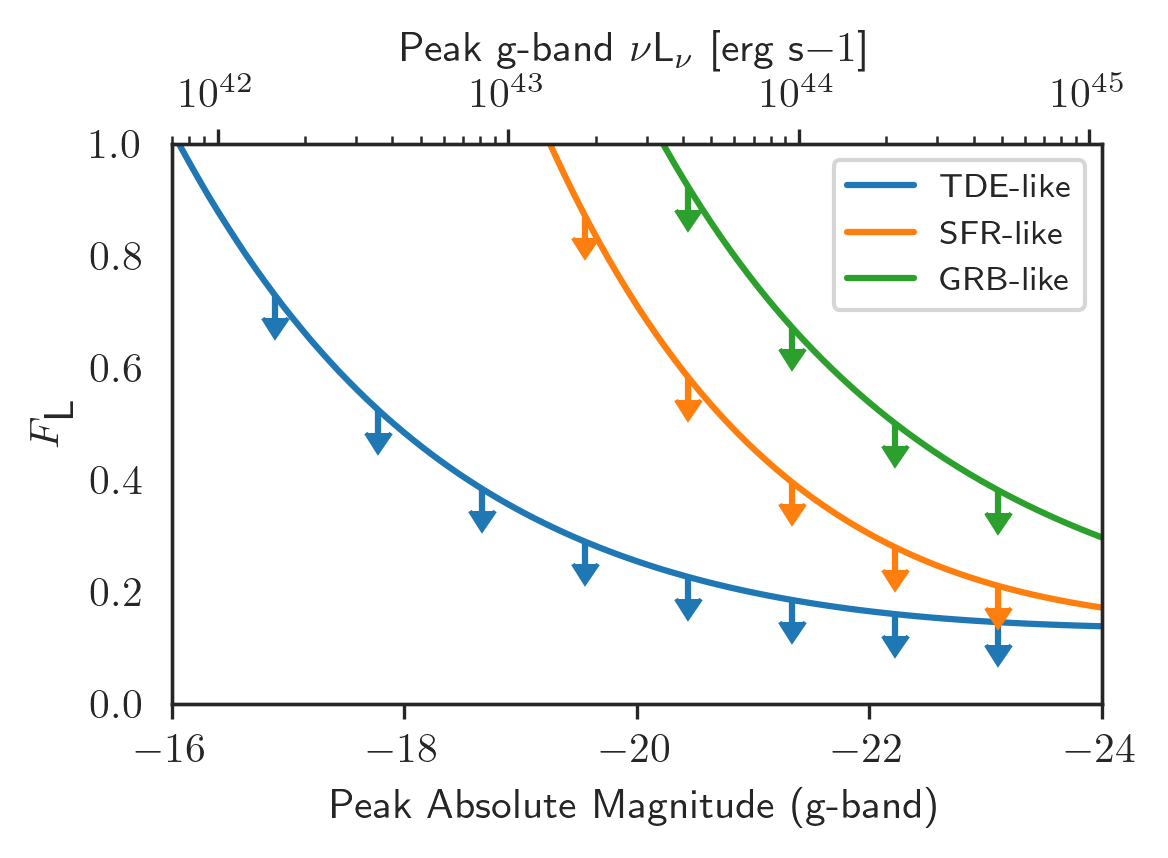

In [15]:
abs_mags = np.linspace(-16., -24, 101)
    
plt.figure(figsize=(base_width, base_height), dpi=dpi)

ax = plt.subplot(111)
plt.gca().invert_xaxis()
ax2 = ax.twiny()
plt.ylim(0.0, 1.0)

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

for i, rate in enumerate(["TDE", "CCSN (Strolger)", "GRB"]):
    
    f = cdf_mpc[rate]
    
    def max_f(abs_mags):
        res = ul/f(max_dl(abs_mags))
        return res
    
    

    ax.plot(abs_mags, max_f(abs_mags), color=f"C{i}", label=labels[rate])

    mag_scatter = np.linspace(abs_mags[0], abs_mags[-1], 10)[1:-1]

    ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.04, uplims=True, color=f"C{i}", linestyle=" ")
    

ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax.set_ylabel(r"$F_{\textup{L}}$", fontsize=big_fontsize)
ax.set_xlabel("Peak Absolute Magnitude (g-band)", fontsize=big_fontsize)
ax2.set_xlabel(r"Peak g-band $\nu$L$_{\nu}$ [erg s${-1}$]", fontsize=big_fontsize)

ax.legend()
xl = abs_mags[0]
xu = abs_mags[-1]

ax.set_xlim(xl, xu)
ax2.set_xlim(abs_mag_to_lum(xl).value, abs_mag_to_lum(xu).value)
ax2.set_xscale("log")

filename = "limit_abs_mag.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

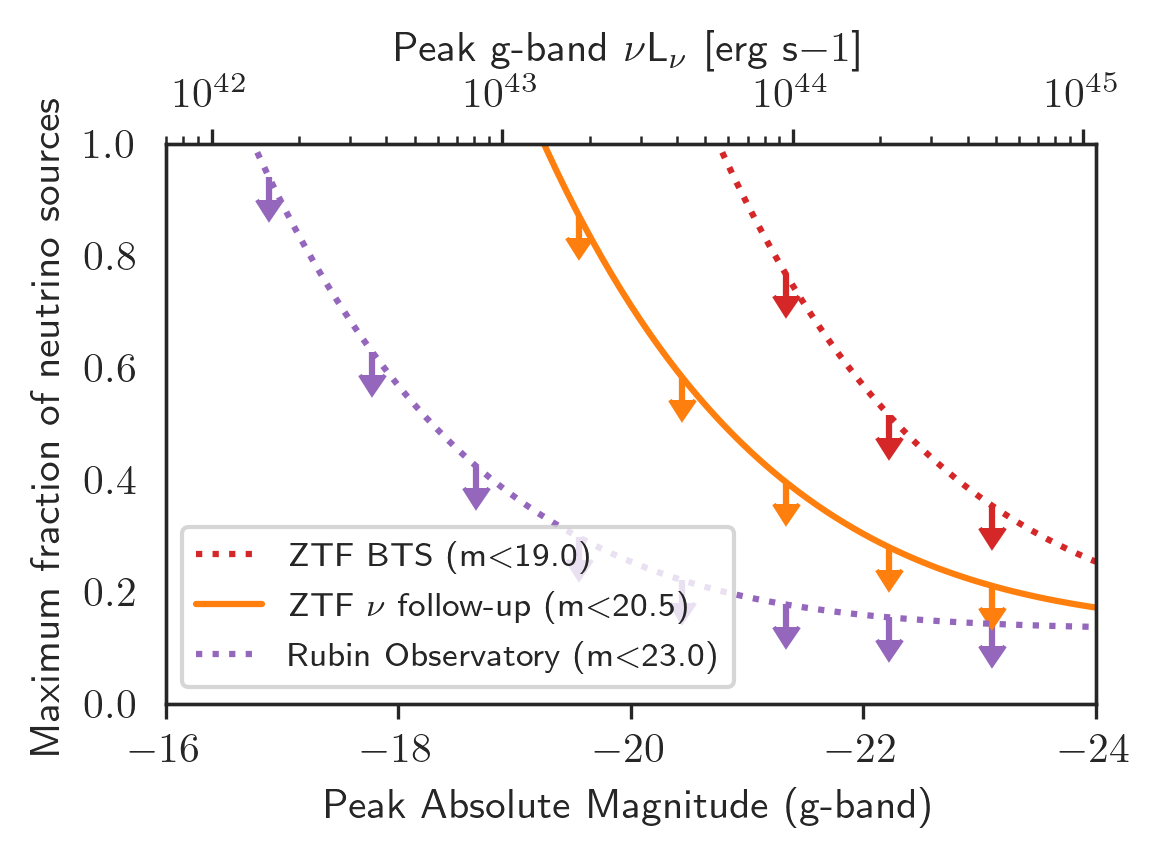

In [16]:
abs_mags = np.linspace(-16., -24, 101)
    
plt.figure(figsize=(base_width, base_height), dpi=dpi)

ax = plt.subplot(111)
plt.gca().invert_xaxis()
ax2 = ax.twiny()
plt.ylim(0.0, 1.0)

f = cdf_mpc["CCSN (Strolger)"]

labels = ["ZTF BTS", r"ZTF $\nu$ follow-up", "Rubin Observatory"]
cs = ["C3", "C1", "C4"]

for i, lim_mag in enumerate([19.0, 20.5, 23.0]):
    
    def max_f(abs_mags):
        res = ul/f(max_dl(abs_mags, lim_mag=lim_mag))
        return res

    ax.plot(abs_mags, max_f(abs_mags), color=cs[i], label=f"{labels[i]} (m$<${lim_mag:.1f})", linestyle=[":", "-", ":"][i])

    mag_scatter = np.linspace(abs_mags[0], abs_mags[-1], 10)[1:-1]

    ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.04, uplims=True, color=cs[i], linestyle=" ")

ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax.set_ylabel(f"Maximum fraction of neutrino sources", fontsize=big_fontsize)
ax.set_xlabel("Peak Absolute Magnitude (g-band)", fontsize=big_fontsize)
ax2.set_xlabel(r"Peak g-band $\nu$L$_{\nu}$ [erg s${-1}$]", fontsize=big_fontsize)

ax.legend()
xl = abs_mags[0]
xu = abs_mags[-1]

ax.set_xlim(xl, xu)
ax2.set_xlim(abs_mag_to_lum(xl).value, abs_mag_to_lum(xu).value)
ax2.set_xscale("log")

filename = "limit_future.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)